# Causal effect estimation with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results. 

This tutorial explains the CausalEffects class from ``causal_effects.py`` which allows to estimate general linear and nonlinear (conditional) causal effects and mediation with optimal adjustment sets. The main background paper explaining optimal adjustment theory is:

J. Runge, Necessary and sufficient graphical conditions for optimal adjustment sets in causal graphical models with hidden variables, Advances in Neural Information Processing Systems, 2021, 34
https://proceedings.neurips.cc/paper/2021/hash/8485ae387a981d783f8764e508151cd9-Abstract.html

__Note:__ the CausalEffects class explicitely addresses not only time series, but also non-time series data.

In [1]:
# Imports

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
from scipy.stats import gaussian_kde

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import Models
from tigramite.causal_effects import CausalEffects

import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
# Find more estimators in sklearn!

/home/jakobrunge/work/code/python_code/tigramite/tigramite_v4/tigramite/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: ('Version mismatch. Installed version of torch', '1.10.2', 'Please install torch>=', '1.11.0')
  warnings.warn(str(e))


# Background: Pearl's causal effect framework and optimal adjustment

A standard problem setting in causal inference is to estimate the causal effect of a variable $X$ on $Y$ given a causal graphical model that specifies qualitative causal relations among observed variables, including a possible presence of hidden confounding variables. This is different from causal discovery where the task is to estimate a causal graph from data. The PC algorithm is a typical causal discovery method and the PCMCI method and its variants PCMCIplus and LPCMCI a modification for time series. Once a causal graph has been estimated with a causal discovery method, one may use it to estimate quantitative causal effects.

## Causal effects

In Pearl's framework the __causal effect__ of setting $X=x$ on $Y$ is a function of the interventional distribution $p(Y|do(X=x))$. This distribution is fundamentally different from the conditional $p(Y|X=x)$! The basis of Pearl's framework is the assumption of an underlying (but unknown) structural causal model (SCM) among random variables, for example,

\begin{align*}
X  &:= f_X(Z, \eta_X) \\
Y & :=  f_Y(X, Z, \eta_Y) \\
Z & :=  f_Z(\eta_Z)
\end{align*}

where $f()$ are to be understood as *assignment functions* by which the value of the random variable on the left is determined by the direct causes (also called parents) and noise terms $\eta_{\cdot}$ on the right-hand-side. These noise terms represent further causal drivers that are assumed to be independent of each other. In the associated graph an edge is drawn from, e.g., $Z$ to $X$ if $X$ occurs as an (non-trivial) argument in the assignment function. This causal graph is assumed acyclic and represents the qualitative causal relations:

<img src="figures/xyz_graph.png" width=150/>

In this SCM $p(Y|do(X=x))$ is to be interpreted as the (interventional) probability distribution of the intervened SCM where the assignment equation of $X$ is replaced:

\begin{align*}
X  &:= x \\
Y & :=  f_Y(X, Z, \eta_Y) \\
Z & :=  f_Z(\eta_Z)
\end{align*}

This mimics the experimental intervention setup. In the corresponding graph all links into the intervened variable are deleted. Given this SCM the __average causal effect__ of the intervention $do(X=x)$ compared to the intervention $do(X=x')$ is defined as

\begin{align*} 
 \Delta_{yxx'} = \mathbb{E}[Y|do(x)] - \mathbb{E}[Y|do(x')]\,.
\end{align*}

### Conditional causal effects

Sometimes, one may be interested in the causal effect *conditional* on values $S=s$ of another variable $S$ in the graph. The __conditional causal effect distribution__ is denoted as

$$
p(Y|do(X=x), S=s) 
$$

and is based on the experiment of first interventionally setting $X=x$ and *then* considering the conditional interventional distribution for $S=s$. Then the __average conditional causal effect__ of the intervention $do(X=x)$ compared to the intervention $do(X=x')$ conditional on $S=s$ is defined as

\begin{align*} 
 \Delta_{yxx'|s} = \mathbb{E}[Y|do(x),s] - \mathbb{E}[Y|do(x'),s]\,.
\end{align*}

### Multivariate causal effects

Multivariate causal effects of $\mathbf{X}$ on $\mathbf{Y}$ are defined accordingly. Note that one can always decompose causal effects on a multivariate $\mathbf{Y}$ into the individual effects on $Y\in\mathbf{Y}$. On the other hand, an intervention in a singleton $X\in\mathbf{X}$ refers to a fundamentally different experiment than an intervention in the whole multivariate $\mathbf{X}$.

## Adjustment

Pearl's theory allows to utilize purely graphical knowledge to employ criteria to characterize whether a causal effect of $X$ on $Y$ among observed variables $\mathbf{V}$ is *identifiable*, i.e., whether the interventional target query can be written as

\begin{align*}
p(Y|do(X=x)) = q(p(\mathbf{V}))
\end{align*}

where $q(p(\mathbf{V}))$ is some function, called the *estimand*, of the observational distribution. The general *do calculus* (Pearl 2009, Shpitser et al., 2010) can be used to completely characterize when this is the case. One class of estimands is based on *backdoor adjustment* where a suitable (possibly empty) set of adjustment variables $\mathbf{Z}$ allows to express the *interventional distribution* for setting $do(X=x)$ in terms of the *observational distribution* as

$$
p(Y|do(X=x)) = \int p(Y|x,\mathbf{z}) p(\mathbf{z}) d\mathbf{z}
$$

for non-empty $\mathbf{Z}$ and as $ p(Y|do(X=x)) = p(Y|x)$ for empty $\mathbf{Z}=\emptyset$. Such a set is  called a *valid adjustment set* relative to ($X,Y$).
To repeat, the clue here is that interventional causal effects can be computed without intervention, but only based on the observational data, if the assumed graph is correct. 

Here we only consider __generalized backdoor adjustment__ which yields a sufficient, but not necessary criterion to identify causal effects. To this end denote by $M$ the mediator nodes on causal paths from $X$ to $Y$ and the *forbidden nodes* as forb$(X,Y)= X\cup des(YM)$ where $des$ denotes the descendants in the graph. According to the *generalized backdoor criterion* (Perkovic et al., 2018) an adjustment set $Z$ is valid if and only if both of the following conditions hold:

1. $\mathbf{Z}\cap \text{forb}=\emptyset$, and 
2. all non-causal paths  from $X$ to $Y$ are blocked by $\mathbf{Z}$. 

A causal path from $X$ to $Y$ consists of only directed edges towards $Y$, all other paths are called non-causal. An adjustment set is called *minimal* if no strict subset of $\mathbf{Z}$ is still valid. 

### Optimal adjustment sets

We denote an estimator given a valid adjustment set $\mathbf{Z}$ as $\widehat{\Delta}_{yxx'|\mathbf{s}.\mathbf{z}}$. Estimators of causal effects based on such a valid adjustment set as a covariate are unbiased, but for different adjustment sets the *estimation variance* may strongly vary. An __optimal adjustment set__ may be characterized as one that has minimal asymptotic estimation variance. More formally, the task is, given a graph and $(X,Y,S)$ ($S$ may be empty), to choose a valid optimal set $\mathbf{Z}$ such that the causal effect estimator's asymptotic variance $\text{Var}(\widehat{\Delta}_{yxx'|\mathbf{s}.\mathbf{z}})=E[(\Delta_{yxx'|\mathbf{s}} - \widehat{\Delta}_{yxx'|\mathbf{s}.\mathbf{z}})^2]$ is minimal:

\begin{align}
\mathbf{Z}_{\rm optimal}\in {\rm argmin}_{\mathbf{Z}} \text{Var}(\widehat{\Delta}_{yxx'|\mathbf{s}.\mathbf{z}})\,.
\end{align}

The optimal adjustment set for general graphical models with hidden variables was derived in Runge (2021) following work by Henckel et l (2019) for the case without hidden variables. Define by $\text{ancs}=an(\mathbf{XYS})\setminus \text{forb}$ the valid anestors. Then the $\mathbf{O}$-set is defined as:

\begin{align*}
\mathbf{O}(\mathbf{X},\mathbf{Y},\mathbf{S}) &= \mathbf{P} \cup \mathbf{C} \cup \mathbf{P}_{\mathbf{C}}, \quad\text{where}\\
   \mathbf{P} &= pa(\mathbf{Y}\mathbf{M}) \setminus \text{forb} \\
   \mathbf{C} &= \{C: C\leftrightarrow \cdots \leftrightarrow W\in\mathbf{YM} ~\text{and}~ (1)~C\notin \text{forb}, ~~~\text{and}~~~ (2a)~C \in \text{ancs} ~\text{or}~ (2b)~C \perp\!\!\!\perp \mathbf{X} ~|~\text{ancs}  \} \\
   \mathbf{P}_{\mathbf{C}} &= pa(\mathbf{C})  
\end{align*}

where  $W\leftrightarrow \cdots \leftrightarrow C$ denotes a collider path. If no hidden variables (or bidirected edges) are present, then $\mathbf{O} = pa(\mathbf{Y}\mathbf{M}) \setminus \text{forb}$, which was derived by Henckel et al. (2019).

For DAGs the $\mathbf{O}$-set is always optimal while for graphs with hidden variables there can be cases where no optimal adjustment set exists that has the smallest variance among all adjustment sets for any distribution consistent with the graph (see paper). For tuples (graph, X, Y, S) where an optimal adjustment set exists we say that *graphical optimality holds*.

Among the theoretical contributions of Runge (2021) are theorems stating that 

1. If and only if a valid backdoor adjustment set exists, then the $\mathbf{O}$-set is a valid adjustment set.
2. The $\mathbf{O}$-set has smaller variance than the Adjust-set for any graph.
3. A complete characterization for which tuples (graph, X, Y, S) graphical optimality holds.

These results were proven to hold for linear estimators. However, in extensive numerical experiments it was shown that the $\mathbf{O}$-set or variants thereof typically outperform other adjustment sets also for estimators based on neural nets, k-nearest neighbors, random forests, or Gaussian processes.

One such variant of the $\mathbf{O}$-set is the *collider-minimized* $\mathbf{O}$-set where collider nodes that do not block non-causal paths are removed. This set has smaller cardinality than the $\mathbf{O}$-set which can help for more complex estimators that suffer from the curse of dimensionality.

## Estimating causal effects through adjustment

We focus on the average treatment effect defined as

\begin{align*} 
 \Delta_{yxx'} = \mathbb{E}[Y|do(x)] - \mathbb{E}[Y|do(x')]\,.
\end{align*}

The individual terms can be estimated using an adjustment set $\mathbf{Z}$ as

\begin{align*} 
\mathbb{E}[Y|do(x)] &= \mathbb{E}_{\mathbf{Z}}\left[ \mathbb{E}_{Y|X,\mathbf{Z}}[Y|X=x, \mathbf{Z}=\mathbf{z}]\right]
\end{align*}

The approach currently implemented in the Tigramite ``CausalEffects`` class  is to estimate the inner expectation by some (here sklearn-) model $Y=\widehat{f}(X,\mathbf{Z})$ from the *observed* data for $(X, Y, \mathbf{Z})$, then evaluate $\widehat{f}(X=x,\mathbf{Z}=\mathbf{z}_t)$ at the *intervened* value $X=x$ and the *observed* values $\mathbf{Z}=\mathbf{z}_t$, and then take the expectation:

\begin{align*} 
\mathbb{E}[Y|do(x)] &= \frac{1}{n} \sum_t \widehat{f}(X=x,\mathbf{Z}=\mathbf{z}_t)
\end{align*}

where $n$ is the sample size of $\mathbf{Z}$.

### Linear case

For the linear case, but here assuming a multivariate intervention in $\mathbf{X}$, the causal effect wrt to $X_i$ can be written as

\begin{align*} 
\frac{\partial }{\partial x_i}\mathbb{E}[Y|do(\mathbf{X}=\mathbf{x})]
\end{align*}

It is equal to the regression coefficient $\beta_{YX_i\cdot \mathbf{Z}\mathbf{X}\setminus X_i}$ in the model

\begin{align*}
 Y &= \sum_i \beta_{YX_i\cdot \mathbf{Z}\mathbf{X}\setminus X_i} X_i + \sum_j \beta_{Y Z_i\cdot \mathbf{X}\mathbf{Z}\setminus Z_i} Z_i   
\end{align*}

### Estimating conditional causal effects

Conditional effects cannot occur in linear models, so this applies only to nonlinear models.

The conditional average treatment effect of a potentially multivariate intervention $do(\mathbf{X}=\mathbf{x})$ compared to the intervention $do(\mathbf{X}=\mathbf{x}')$ given $\mathbf{S}=\mathbf{s}$ is defined as follows:

\begin{align*} 
 \Delta_{y\mathbf{x}\mathbf{x}'|\mathbf{s}} = \mathbb{E}[Y|do(\mathbf{x}),\mathbf{s}] - \mathbb{E}[Y|do(\mathbf{x}'),\mathbf{s}]\,.
\end{align*}

The individual terms can be estimated using an adjustment set $\mathbf{Z}$ as

\begin{align*} 
\mathbb{E}[Y|do(\mathbf{x}),\mathbf{s}] &= \mathbb{E}_{\mathbf{Z}|\mathbf{S}}\left[ \mathbb{E}_{Y|\mathbf{X},\mathbf{Z},\mathbf{S}}[Y|\mathbf{X}=\mathbf{x}, \mathbf{Z}=\mathbf{z}, \mathbf{S}=\mathbf{s}] | \mathbf{S}=\mathbf{s}\right]
\end{align*}

In its current implementation, these nested expectations are estimated by a nested regression where the inner expectation uses the ``estimator`` model and the outer expectation the ``conditional_estimator`` model. More specifially, the steps are:

1. Fit inner expectation $Y = f(\mathbf{X}=\mathbf{x}_t,\mathbf{Z}=\mathbf{z}_t,\mathbf{S}=\mathbf{s}_t)$ using the ``estimator`` model on the observed data (indexed by $t$)
2. Predict $\widehat{Y}_{\mathbf{X}\mathbf{Z}\mathbf{S}} = \widehat{f}(\mathbf{X}=\mathbf{x},\mathbf{Z}=\mathbf{z}_t,\mathbf{S}=\mathbf{s})$, where $\mathbf{z}_t$ are the *observed* values, $\mathbf{x}$ the *interventional* values, and $\mathbf{s}$ are the conditional values
3. Fit outer expectation $\widehat{Y}_{\mathbf{X}\mathbf{Z}\mathbf{S}} = g(\mathbf{S}=\mathbf{s}_t)$ using the ``conditional_estimator`` model on the *observational* values of $\mathbf{S}$
4. Predict $\widehat{Y}_{do(\mathbf{X}),\mathbf{S}} = \widehat{g}(\mathbf{S}=\mathbf{s})$ where $\mathbf{s}$ are the *conditional* values of $\mathbf{S}$


## Estimating linear effects with the Wright estimator

Sewall Wright (Wright 1921) suggested already hundred years ago to estimate causal effects in linear models in a particular way that first estimates the so-called *path coefficients* for all links belonging to causal paths and then takes the sum over all causal paths of the products of these path coefficients. 

This approach only applies to DAGs and the estimator steps are:

1. For all causal links $i\to j$ belonging to causal paths from $X$ to $Y$, estimate the path coefficient $\beta_{i\to j}$ by regressing $j$ on all its parents and taking the coefficient belonging to parent $i$.
2. Then the causal effect is

$$
CE = \sum_{\text{causal paths}} \prod_{\text{link $i\to j$ in path}} \beta_{i\to j}
$$

By restricting this estimator to only paths that pass at least through one node among selected *mediators* $M^*$ one can also compute mediated causal effects (MCE). 

$$
MCE = \sum_{\text{causal paths through at least one $M\in M^*$}} \prod_{\text{link $i\to j$ in path}} \beta_{i\to j}
$$

This is also implemented in the class through the parameter ``mediation``. For ``mediation='direct'`` only the __direct effect__ in the coefficient $\beta_{X\to Y}$, if non-zero, is returned.

## Types of graphs describing qualitative causal knowledge

### Non-time series data

Qualitative knowledge may come in different forms. For example, one may further assume that some variables in the __directed acyclic graph (DAG)__ are unobserved, here L:

<img src="figures/xyzl_graph.png" width=150/>

Another way to represent the presence of hidden variables is through an __acyclic directed mixed graph (ADMG)__, which would here be

<img src="figures/xyzl_graph_bi.png" width=150/>

An ADMG has directed and bidirected edges representing one or more latent confounder variables.

### Time series data

In the context of time series, we consider time-dependent SCMs. An important assumption is that of stationarity, i.e., the SCM does not depend on a time point $t$. Then one may represent each variable at different instances of time as a node resulting in a __stationary DAG (statDAG)__: 

<img src="figures/tsg_graph.png" width=400/>

The stationarity assumption implies that this graph repeats into the past and future. Knowledge of all causal edges at time $t$ then suffices to represent all causal relations. The causal link with the maximal time lag (here 2) then defines the *order* of the process. In the above example you can see that a feesback cycle in the summary graph (left) actually is still a non-cyclic time series graph.

## Limitations of currently implemented methods

The theory of stationary time series DAGs *with hidden variables* is much more complex and currently not treated in Tigramite. However, ADMGs are treated for the non-time series case.

As mentioned above, the theoretical results on optimal adjustment sets have so far been only established for linear least-squares estimators and singleton $X$, but the numerical results show that the $\mathbf{O}$-set or minimized variants thereof also hold for multivariate $X$ and often yield smaller variance also in non-optimal settings and for non-parametric estimators such as kNN, neural networks, gaussian processes, or random forests.

## References

* Pearl, J. (2009). Causality: Models, reasoning, and inference. Cambridge University Press. 

* Perković, E., Textor, J., and Kalisch, M. (2018). Complete graphical characterization and construction of adjustment sets in markov equivalence classes of ancestral graphs. Journal of Machine Learning Research, 18:1–62.

* Shpitser, I., VanderWeele, T., and Robins, J. M. (2010). On the validity of covariate adjustment for estimating causal effects.

* Runge, J. (2021). Necessary and sufficient graphical conditions for optimal adjustment sets in causal graphical models with hidden variables. Advances in Neural Information Processing Systems, 34.

* Henckel, L.; Perković, E. & Maathuis, M. H. (2019). Graphical criteria for efficient total effect estimation via adjustment in causal linear models arXiv preprint arXiv:1907.02435

* Wright, S. (1921). Correlation and causation. J. Agric. Res., 20, 557-585 

# Causal Effect class

## Initialization

``CausalEffects`` takes the following arguments:

### ``graph``, ``graph_type``, and ``hidden_variables``

``graph`` is a string array of ``dtype='<U3'`` in different shapes depending on ``graph_type``:

* ``graph_type='dag'`` denotes a non-time series DAG where ``graph`` is of shape ``(N,N)`` with N denoting the number of nodes
* ``graph_type='admg'`` denotes a non-time series ADMG where ``graph`` is of shape ``(N,N)``
* ``graph_type='stationary_dag'`` denotes a stationary time series DAG where ``graph`` is of shape ``(N,N, tau_max + 1)`` where ``tau_max`` is the maximal time lag. The ``+1`` stands for contemporaneous relations. 

``hidden_variables`` is a list of tuples ``[(k, -tau), ...]`` containing hidden variables or, for time series graphs, more generally also only selected hidden time points of a variable ``k``. For example, ``(k, -tau)`` denotes $X^k_{t-\tau}$. Note that currently hidden variables are not supported for time series.

In each case the entries of the graph are of ``dtype='<U3'``: 

For ``graph_type='dag'`` the edges can be ``<--`` or ``-->``. For example, with variables $(L,X,Z,Y)$ the DAG above would be given as

```
graph = np.array([['', '-->', '-->', ''],
                  ['<--', '', '', '-->'],
                  ['<--', '', '', '-->'],
                  ['', '<--', '<--', '']], dtype='<U3')
```

together with ``hidden_variables=[(0,0)]``.

As an ADMG for ``graph_type='admg'`` the edges can be ``<--``, ``-->``,  ``<->``, ``+->``, or  ``<-+``. For example, with variables $(X,Z,Y)$ it would be 

```
graph = np.array([['', '<->', '-->'],
                   ['<->', '', '-->'],
                   ['<--', '<--', '']], dtype='<U3')
```

The edge types ``+->`` and ``<-+`` represent the presence of both a directed and bidirected edge.

Note that ``hidden_variables`` can also be specified for ADMG input, then internally a modified ADMG is constructed based on the *latent projection* operation (Pearl 2009).

Finally, for ``graph_type='stationary_dag'`` the edges can be ``-->`` for time-lagged and contemporaneous links, and ``<--`` only for contemporaneous links, i.e., in ``graph[:,:,0]``. For example, for variables $(X^1,X^2,X^3)$ the graph in the section above would be given as

```
graph =  np.array([[['', '-->', ''],
                    ['', '', ''],
                    ['', '', '']],
                   [['', '-->', ''],
                    ['', '-->', ''],
                    ['-->', '', '-->']],
                   [['', '', ''],
                    ['<--', '', ''],
                    ['', '-->', '']]], dtype='<U3')
```

In all cases, the graph must be acyclic and have consistent edges, for example, ``graph[i,j,taui,tauj]='-->'`` requires ``graph[j,i,tauj,taui]='<--'``. For the stationary DAG this is only relevant for the zero lag, i.e., in ``graph[:,:,0]``.

Internally, the ``CausalEffects`` class will convert a stationary DAG into an ADMG via a latent projection operation of shape ``(N,N, tau_max + 1, tau_max + 1)``. In this ADMG the adjustment sets are then computed. Such graphs can also directly by given as ``graph`` for ``graph_type='tsg_admg'`` or ``graph_type='tsg_dag'``.


### ``X``,  ``Y``, and optionally  ``S``

These represent the cause variable(s) $X$, the effect variable(s) $Y$ and, optionally, the conditioning variable(s) $S$. All are lists of tuples ``[(i, -tau), ...]`` for ``tau``$\geq 0$. Given the graph, the class will check that no overlap exists, and that there actually is a causal path from $X$ to $Y$. Further, the conditions $S$ must not be in the forbidden set.

Let's start with the simple DAG with hidden variables above.

In [2]:
graph = np.array([['', '-->', '-->', ''],
                  ['<--', '', '', '-->'],
                  ['<--', '', '', '-->'],
                  ['', '<--', '<--', '']], dtype='<U3')
hidden_variables = [(0,0)]
X = [(1,0)]
Y = [(3,0)]
causal_effects = CausalEffects(graph, graph_type='dag', X=X, Y=Y, S=None, 
                               hidden_variables=hidden_variables, 
                               verbosity=1)


##
## Initializing CausalEffects class
##

Input:

graph_type = dag
X = [(1, 0)]
Y = [(3, 0)]
S = []
M = []

hidden_variables = {(0, 0)}





Internally, the DAG with hidden variables will be converted to an ADMG through the latent projection operation. Let's plot the ADMG using the ``plot_graph`` function from the ``tigramite.plotting`` module. You can have a look at the docstring to see further options to change the position of nodes, coloring, etc.

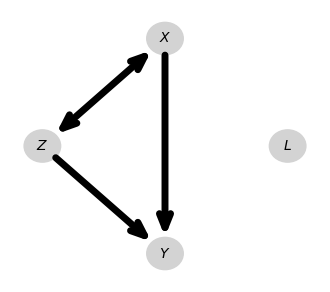

In [3]:
# Just for plotting purposes
var_names = ['$L$', '$X$', '$Z$', '$Y$']
tp.plot_graph(graph = causal_effects.graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (4, 4),
        ); plt.show()

    Next we show the stationary time series DAG from above using the ``plot_time_series_graph`` function.


##
## Initializing CausalEffects class
##

Input:

graph_type = stationary_dag
X = [(1, -2)]
Y = [(2, 0)]
S = []
M = [(1, 0), (2, -1), (2, -2), (1, -1)]





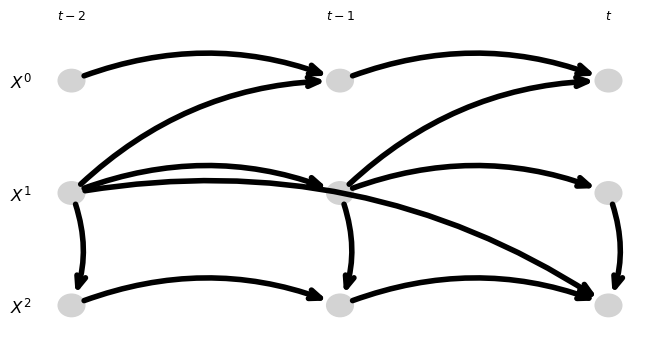

In [4]:
graph =  np.array([[['', '-->', ''],
                    ['', '', ''],
                    ['', '', '']],
                   [['', '-->', ''],
                    ['', '-->', ''],
                    ['-->', '', '-->']],
                   [['', '', ''],
                    ['<--', '', ''],
                    ['', '-->', '']]], dtype='<U3')

X = [(1,-2)]
Y = [(2,0)]
causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                               hidden_variables=None, #[(1, -1)], 
                               verbosity=1)
var_names = ['$X^0$', '$X^1$', '$X^2$']
tp.plot_time_series_graph(graph = graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (8, 4),
        ); plt.show()

The above graph is a time series graph that is assumed stationary and, hence, repeats the above edges to the past and future. Internally, the ``CausalEffects`` class doesn't deal with these infinite graph, but rather constructs a finite ADMG with the same d-separations via a (more involved) latent projection operation for stationary graphs.

Below is this finite ``tsg_admg`` on which adjustment and paths are based.

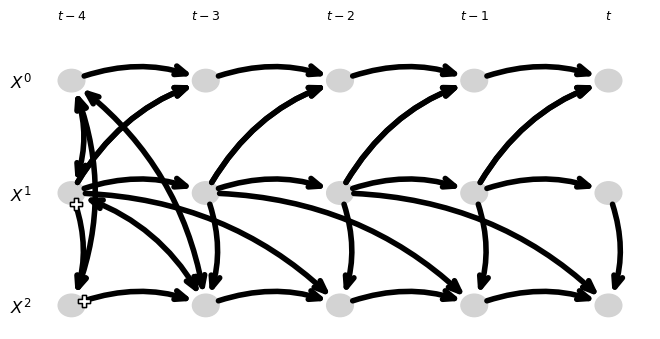

In [5]:
tp.plot_time_series_graph(graph = causal_effects.graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (8, 4),
        ); plt.show()

The graph shown is the ADMG extended to $\tau_{\max}=maxlag(X,Y,S)+graph.shape[2] - 1$ (here $\tau_{\max}=4$). The reasoning behind this choice is that the $\mathbf{O}$-set consisting of the parents of $Y$ and $M$ can then be fully reconstructed and, hence, is a valid adjustment set. 

You may also use the static method ``CausalEffects.get_graph_from_dict(links, tau_max=None)`` to generate a graph from a link dictionary of the form ``{0:[(0, -1), ...], 1:[...], ...}``. Also the format ``{0:[((0, -1), coeff, func), ...], 1:[...], ...}`` is allowed which is used to generate toy model data in tigramite. The ``coeff`` and ``func`` parameters are ignored for the graph construction. The shape of ``graph`` will be ``(N, N, tau_max+1)`` where ``tau_max`` is either automatically inferred from the dictionary or can be given as an argument. If you want greate a non-timeseries DAG of shape ``(N, N)``, just provide links with zero-lag and then squeeze the graph:  ``dag_graph=graph.squeeze()``.

Since it's a static method, you do *not* need to intitialize ``CausalEffects`` beforehand!

In [6]:
def lin_f(x): return x
links = {0: [(0, -1)],
         1: [(1, -1), (0, -3)],
         2: [(2, -1), (1, 0)],
         }
graph = CausalEffects.get_graph_from_dict(links, tau_max=None)
print(graph)

[[['' '-->' '' '']
  ['' '' '' '-->']
  ['' '' '' '']]

 [['' '' '' '']
  ['' '-->' '' '']
  ['-->' '' '' '']]

 [['' '' '' '']
  ['<--' '' '' '']
  ['' '-->' '' '']]]


Let's consider a more complex non-time series ADMG with multivariate $X$.

In [7]:
graph =  np.array([['', '-->', '', '', '', '', ''],
                   ['<--', '', '-->', '-->', '', '<--', ''],
                   ['', '<--', '', '-->', '', '<--', ''],
                   ['', '<--', '<--', '', '<->', '', '<--'],
                   ['', '', '', '<->', '', '<--', ''],
                   ['', '-->', '-->', '', '-->', '', ''],
                   ['', '', '', '-->', '', '', '']], dtype='<U3')

X = [(0,0), (1,0)]
Y = [(3,0)]
causal_effects = CausalEffects(graph, graph_type='admg', X=X, Y=Y, S=None, hidden_variables=None, 
                            verbosity=1)
# Just for plotting purposes
var_names = ['$X_1$', '$X_2$', '$M$', '$Y$', '$Z_1$', '$Z_2$', '$Z_3$']



##
## Initializing CausalEffects class
##

Input:

graph_type = admg
X = [(0, 0), (1, 0)]
Y = [(3, 0)]
S = []
M = [(2, 0)]





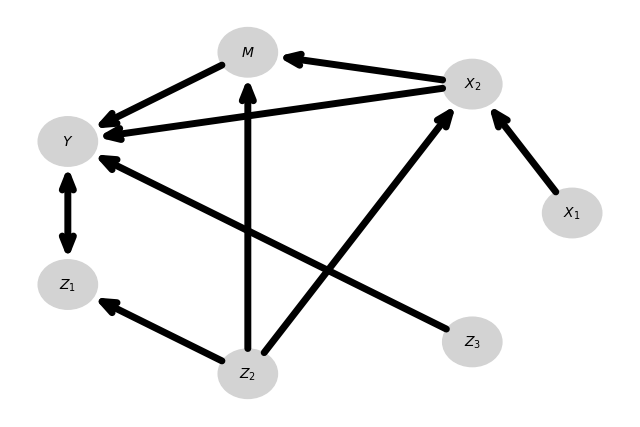

In [8]:
tp.plot_graph(graph = graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (8, 6),
        ); plt.show()

## Checks

The mediators $M$ are automatically computed from the graph. This is an ADMG since there is a bidirected edge between $Y$ and $Z_1$.

Before considering adjustment sets, we can check whether one can actually remove nodes from $\mathbf{X}$ (or $\mathbf{Y}$) that do not contribute to proper causal paths.

In [9]:
newX, newY = causal_effects.check_XYS_paths()

Consider pruning X = {(1, 0), (0, 0)} to X = {(1, 0)} since only these have causal path to Y


Here this is the case, but we will keep the original $X$ since it doesn't change the causal effect estimation.

## Adjustment sets

We could now directly move on to the ``fit_total_effect`` and ``predict_total_effect`` functions which automatically use the optimal adjustment set. But before that, we briefly discuss different possible adjustment sets.

The default implemented in the class is the $\mathbf{O}$-set. For the graph above it would be:

In [10]:
opt = causal_effects.get_optimal_set()
print("Oset = ", [(var_names[v[0]], v[1]) for v in opt])


Oset =  [('$Z_1$', 0), ('$Z_2$', 0), ('$Z_3$', 0)]


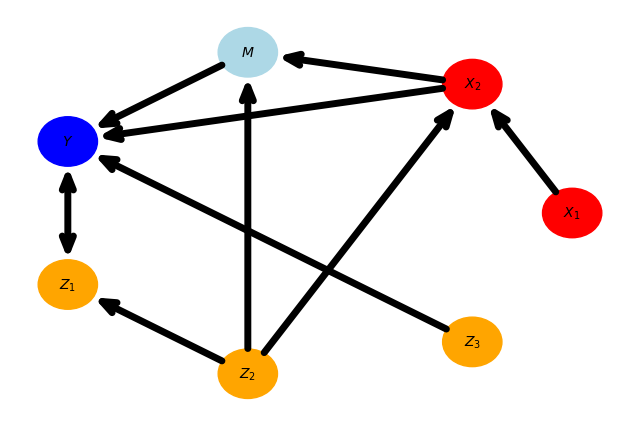

In [11]:
special_nodes = {}
for node in causal_effects.X:
    special_nodes[node] = 'red'
for node in causal_effects.Y:
    special_nodes[node] = 'blue'
for node in opt:
    special_nodes[node] = 'orange'
for node in causal_effects.M:
    special_nodes[node] = 'lightblue'

tp.plot_graph(graph = graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (8, 6),
        special_nodes=special_nodes,
        ); plt.show()

Here it consists of the parents of $Y$ and $M$ (here $Z_3,Z_2$), *valid collider paths* emanating from $YM$ (here $Y\leftrightarrow Z_1$), and the parents of these valid colliders (here $Z_2$, which is already part of the set). 

An alternative is the ancs-set defined above (Perkovic et al., 2018) which consists of the ancestors of X and Y (and optionally S) from which forbidden nodes are removed.

In [12]:
adj = causal_effects._get_adjust_set()
print("Adjust-set = ", [(var_names[v[0]], v[1]) for v in adj])

Adjust-set =  [('$Z_2$', 0), ('$Z_3$', 0)]


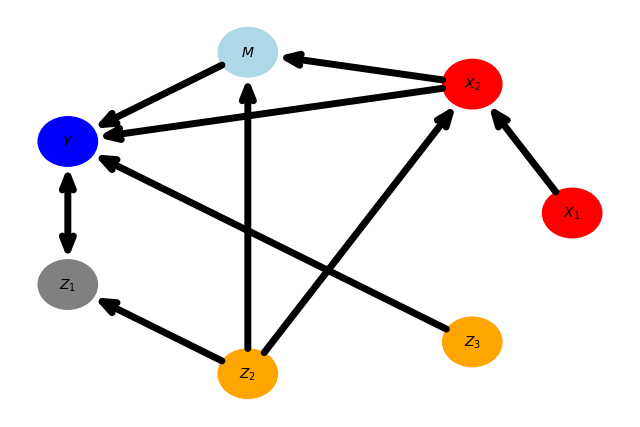

In [13]:
special_nodes = {}
for node in causal_effects.X:
    special_nodes[node] = 'red'
for node in causal_effects.Y:
    special_nodes[node] = 'blue'
for node in adj:
    special_nodes[node] = 'orange'
for node in causal_effects.M:
    special_nodes[node] = 'lightblue'

tp.plot_graph(graph = graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (8, 6),
        special_nodes=special_nodes,
        ); plt.show()

The difference to the optimal set is that the node $Z_1$ is not part of the Adjust-set. However, as studied in the paper, adding valid collider path nodes of Y and M (and their parents) to the adjustment set helps to reduce the estimators variance.

Here the *collider-minimized* $\mathbf{O}$-set would be:

Cmin-Oset =  [('$Z_2$', 0), ('$Z_3$', 0)]


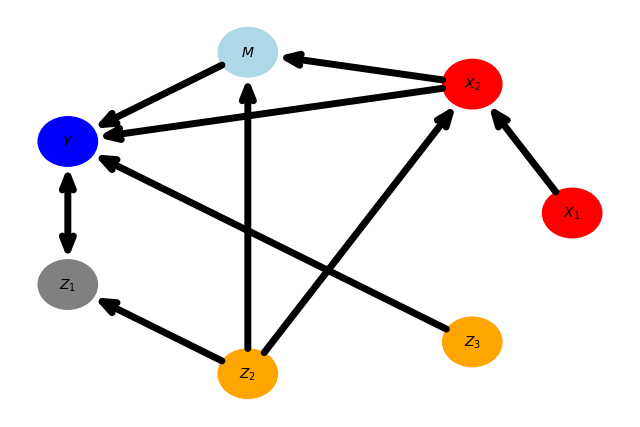

In [14]:
cminopt = causal_effects.get_optimal_set(minimize='colliders_only')
print("Cmin-Oset = ", [(var_names[v[0]], v[1]) for v in cminopt])
special_nodes = {}
for node in causal_effects.X:
    special_nodes[node] = 'red'
for node in causal_effects.Y:
    special_nodes[node] = 'blue'
for node in cminopt:
    special_nodes[node] = 'orange'
for node in causal_effects.M:
    special_nodes[node] = 'lightblue'

tp.plot_graph(graph = graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (8, 6),
        special_nodes=special_nodes,
        ); plt.show()

Here $Z_1$ is removed.

Let's check whether for this setting *graphical optimality* holds.

In [15]:
optimality = causal_effects.check_optimality()
print("(Graph, X, Y, S) fulfills optimality: ", optimality)

(Graph, X, Y, S) fulfills optimality:  True


Hence, for this graph the $\mathbf{O}$-set yields the smallest asymptotic estimation variance for *any* distribution consistent with the graph, at least for linear estimators.

## Estimating general total causal effects 

We now move to estimating total causal effects utilizing graphical generalized backdoor adjustment with the optimal adjustment set.

### Ground truth toy model
First let's generate some data from an SCM with the above graph using the tigramite function ``toys.structural_causal_process`` with Gaussian unit variance noise (``noises=None``)

In [16]:
def lin_f(x): return x
coeff = .5
links_coeffs = {
                0: [], 
                1: [((0, 0), coeff, lin_f), ((5, 0), coeff, lin_f)], 
                2: [((1, 0), coeff, lin_f), ((5, 0), coeff, lin_f)],
                3: [((1, 0), coeff, lin_f), ((2, 0), coeff, lin_f), ((6, 0), coeff, lin_f), ((7, 0), coeff, lin_f)],
                4: [((5, 0), coeff, lin_f), ((7, 0), coeff, lin_f)], 
                5: [],
                6: [],
                7: [],
                }
T = 10000
data, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7)
# Time series no 7 is unobserved confounder
data = data[:, [0,1,2,3,4,5,6]]
dataframe = pp.DataFrame(data)

First, we plot data. This can be done with the function ``tp.plot_timeseries``

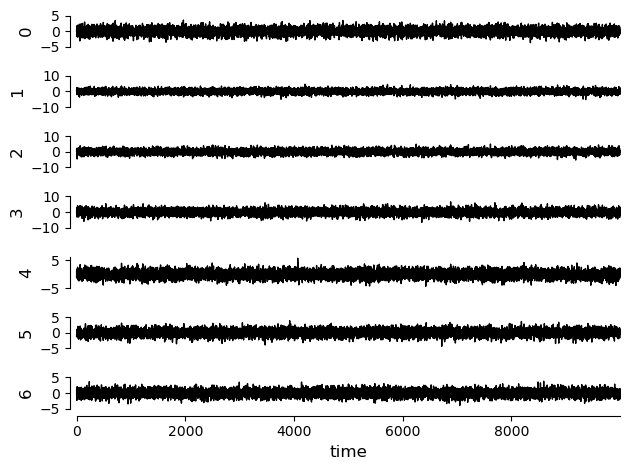

In [17]:
tp.plot_timeseries(dataframe); plt.show()

### Ground truth interventional data

Before predicting the effect of interventions, we take a look at the ground truth, which we can generate here since we have the underlying SCM. We generate the interventional data for the two interventions $x_1=x_2=1$ and $x_1'=x_2'=0$

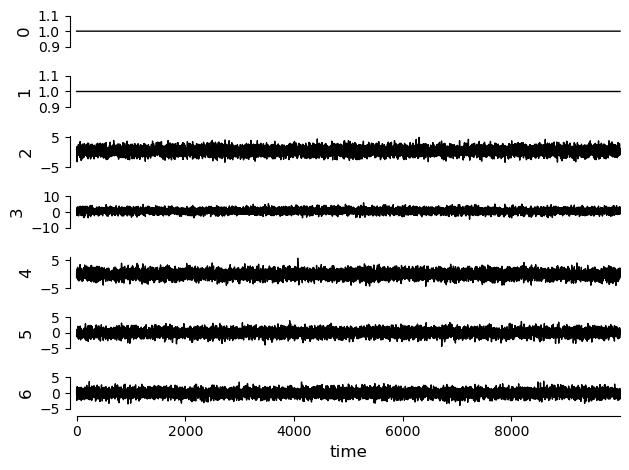

In [18]:
T = 10000
intervention1 = np.ones(T)
intervention_data1, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7,
                                            intervention={X[0][0]:intervention1, X[1][0]:intervention1}, 
                                            intervention_type='hard',)
# Time series no 7 is unobserved confounder
intervention_data1 = intervention_data1[:, [0,1,2,3,4,5,6]]
tp.plot_timeseries(pp.DataFrame(intervention_data1)); plt.show()

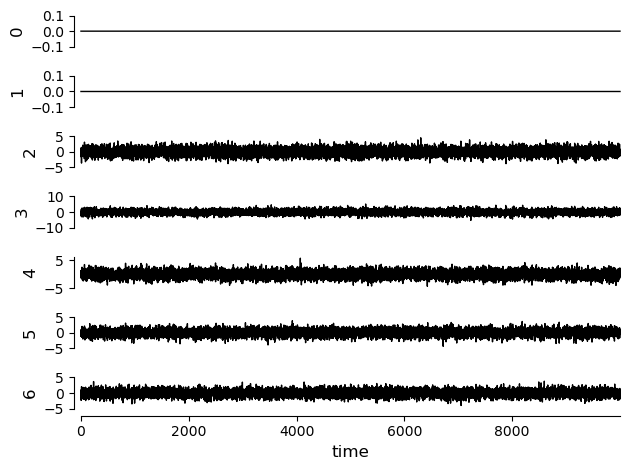

In [19]:
intervention2 = 0.*np.ones(T)
intervention_data2, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7,
                                            intervention={X[0][0]:intervention2, X[1][0]:intervention2}, 
                                            intervention_type='hard',)
# Time series no 7 is unobserved confounder
intervention_data2 = intervention_data2[:, [0,1,2,3,4,5,6]]
tp.plot_timeseries(pp.DataFrame(intervention_data2)); plt.show()

The true average treatment effect is then simply the average difference of the $Y$-data:

In [20]:
true_effect = (intervention_data1[:,Y[0][0]] - intervention_data2[:,Y[0][0]]).mean()
print("True effect = %.2f" %true_effect)

True effect = 0.75


The value 0.75 here emerges as the sum of the direct causal link $X_2\to Y$ with coefficient 0.5 and the indirect path $X_2\to M \to Y$ where the effect is the product of $0.5 \times 0.5 = 0.25$.

### Fitting the causal effect adjustment model

We focus on the average treatment effect implemented in the ``fit_total_effect`` and ``predict_total_effect`` functions. The former takes as the most relevant input a ``dataframe`` and a sklearn model as an ``estimator`` object, here linear regression. The default for the ``adjustment_set`` is the optimal set. Since $S$ is empty, here we don't consider conditional causal effects. This case is discussed further below. 

Here we leave the data as it is and perform no standardization, which could be done with ``data_transform``. ``mask_type`` can be used for masking data samples (e.g., winter months).

In [21]:
causal_effects.fit_total_effect(
        dataframe=dataframe, 
        estimator=LinearRegression(),
        adjustment_set='optimal',
        conditional_estimator=None,  
        data_transform=None,
        mask_type=None,
        )

### Predicting the effect of interventions

Now we use the fitted causal effect model to predict the effect of the two interventions $x_1=x_2=1$ and $x_1'=x_2'=0$ yielding the expected values of $Y$. The function ``predict_total_effect`` takes as arguments ``intervention_data``, ``conditions_data``, and ``pred_params``. ``pred_params`` are optional parameters passed on to sklearn prediction function. ``intervention_data`` must be of shape ``(1, len(X))`` to predict the intervention of single value(s) $\mathbf{X}=\mathbf{x}$ or ``(T_x, len(X))`` to predict the effect of a range of values of length $T_x$. Correspondingly, ``conditions_data`` must be of shape ``(T_x, len(S))``, i.e., of the same length as ``intervention_data``.

In [22]:
intervention_data = 1.*np.ones((1, 2))
y1 = causal_effects.predict_total_effect( 
        intervention_data=intervention_data,
#         conditions_data=conditions_data,
        )
print("y1 = ",y1)

intervention_data = 0.*np.ones((1, 2))
y2 = causal_effects.predict_total_effect( 
        intervention_data=intervention_data,
#         conditions_data=conditions_data,
        )
print("y2 = ",y2)

y1 =  [[0.73288064]]
y2 =  [[-0.00799763]]


``predict_total_effect`` returns the expected causal effects in an array of shape ``(T_x, len(Y))``. The average treatment effect is then given by the difference:

In [23]:
beta = (y1 - y2)
print("Causal effect = %.2f" %(beta))


Causal effect = 0.74


As you can see, it is almost the true causal effect from above. 

We can also directly compute the effect of a range of intervention values:

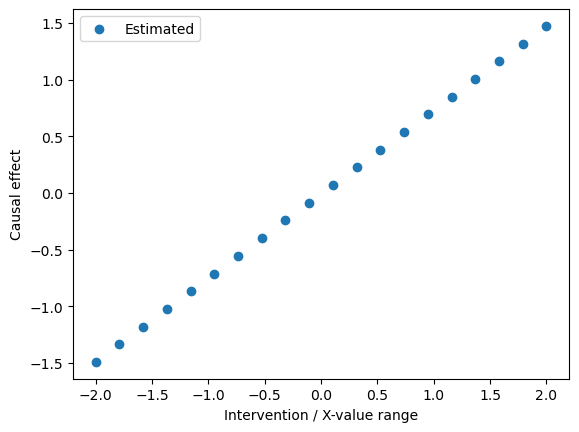

In [24]:
intervention_data = np.tile(np.linspace(-2, 2, 20).reshape(20, 1), (1, 2))
estimated_causal_effects = causal_effects.predict_total_effect( 
        intervention_data=intervention_data,
#         conditions_data=conditions_data,
        )
plt.scatter(intervention_data[:,0], estimated_causal_effects[:,0], label="Estimated")
# plt.plot(intervention_values, true_causal_effects, 'k-', label="True")
# plt.title(r"NRMSE = %.2f" % (np.abs(estimated_causal_effects - true_causal_effects).mean()/true_causal_effects.std()))
plt.xlabel('Intervention / X-value range')
plt.ylabel('Causal effect')
plt.legend()
plt.show()


Here this is just a straight line of slope $0.75$ since we deal with a linear model.

### Other estimator models

#### Nonlinear / non-parametric estimators

Here the ground truth is linear, so it made sense to use a linear estimator. Let's consider a nonlinear ground truth and generate observational as well interventional ground truth data for a range of intervention values.

In [25]:
def lin_f(x): return x
def nonlin_f(x): return (x + 5. * x ** 2 * np.exp(-x ** 2 / 20.))

coeff = .5
links_coeffs = {
                0: [], 
                1: [((0, 0), coeff, lin_f), ((5, 0), coeff, lin_f)], 
                2: [((1, 0), -coeff, nonlin_f), ((5, 0), coeff, lin_f)],
                3: [((1, 0), 1., nonlin_f), ((2, 0), coeff, lin_f), ((6, 0), coeff, lin_f), ((7, 0), coeff, lin_f)],
                4: [((5, 0), coeff, lin_f), ((7, 0), coeff, lin_f)], 
                5: [],
                6: [],
                7: [],
                }
# Observational data
T = 1000
data, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7)
# Time series no 7 is unobserved confounder
data = data[:, [0,1,2,3,4,5,6]]
dataframe = pp.DataFrame(data)

# Interventional data for a range of intervention values
intervention_data = np.linspace(-10, 10, 30)

true_causal_effects = np.zeros(len(intervention_data))
for i, int_val in enumerate(intervention_data): 
    intervention1 = int_val*np.ones(T)
    intervention_data1, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7,
                                            intervention={0:intervention1, 1:intervention1}, 
                                            intervention_type='hard',)
    # Time series no 7 is unobserved confounder
    intervention_data1 = intervention_data1[:, [0,1,2,3,4,5,6]]
    true_causal_effects[i] = intervention_data1[:,Y[0][0]].mean()

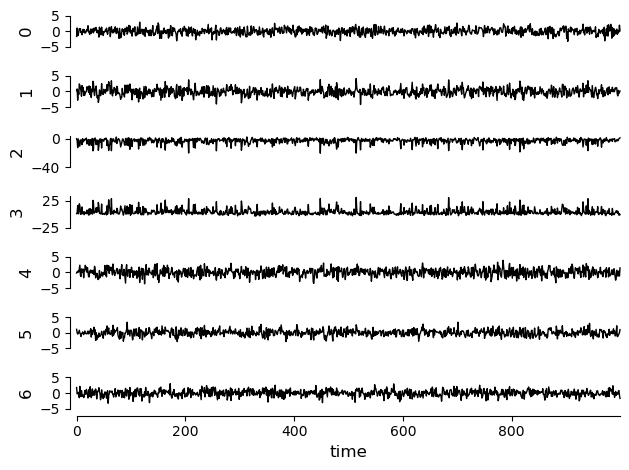

In [26]:
tp.plot_timeseries(dataframe); plt.show()

Now we fit *on the observational data* using the non-parametric ``KNeighborsRegressor()`` and then estimate the effect of the above considered interventions.

In [27]:
# Fit causal effect model from observational data
causal_effects.fit_total_effect(
        dataframe=dataframe, 
        estimator=KNeighborsRegressor(),
        adjustment_set='optimal',
        conditional_estimator=None,  
        data_transform=None,
        mask_type=None,
        )

# Predict effect of interventions
intervention_data_here = np.tile(intervention_data.reshape(30, 1), (1, 2))

estimated_causal_effects = causal_effects.predict_total_effect( 
        intervention_data=intervention_data_here,
#         conditions_data=conditions_data,
        )

Below we compare the true and predicted causal effect values in $Y$ (y-axis) given intervention values in $X$ on the x-axis.

In addition, we show the observational density of $X_1$ (red).

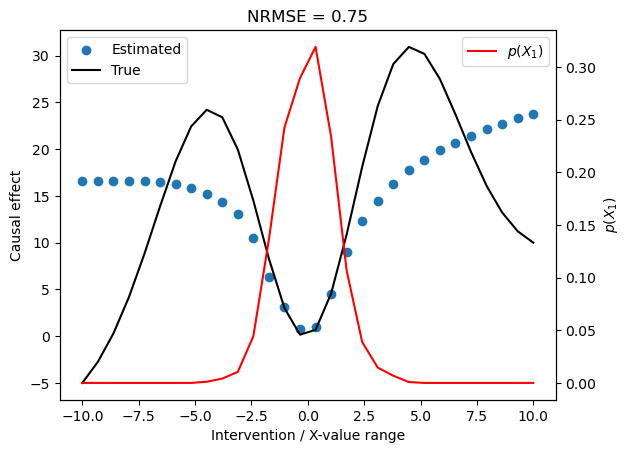

In [28]:
plt.scatter(intervention_data, estimated_causal_effects[:,0], label="Estimated")
plt.plot(intervention_data, true_causal_effects, 'k-', label="True")
plt.title(r"NRMSE = %.2f" % (np.abs(estimated_causal_effects[:,0] - true_causal_effects).mean()/true_causal_effects.std()))
plt.xlabel('Intervention / X-value range')
plt.ylabel('Causal effect')
plt.legend()

# Also show observational density of X1
ax2 = plt.gca().twinx()
density = gaussian_kde(data[:,1])
ax2.plot(intervention_data, density(intervention_data), 'r-', label=r"$p(X_1)$")
ax2.set_ylabel(r'$p(X_1)$')
ax2.legend(loc='upper right')

plt.show()

The causal effect estimate works well for the range of values where the observational distribution of $X$ is non-zero. The kNN-estimator model cannot learn functional relations outside this range.

#### Logistic regression

Now let's have a look at ``LogisticRegression`` which allows to fit a categorical target (=response) variable to continuous input variables. To this end, we here use ``pp.quantile_bin_array`` to get categorical toy data for the target $Y$.

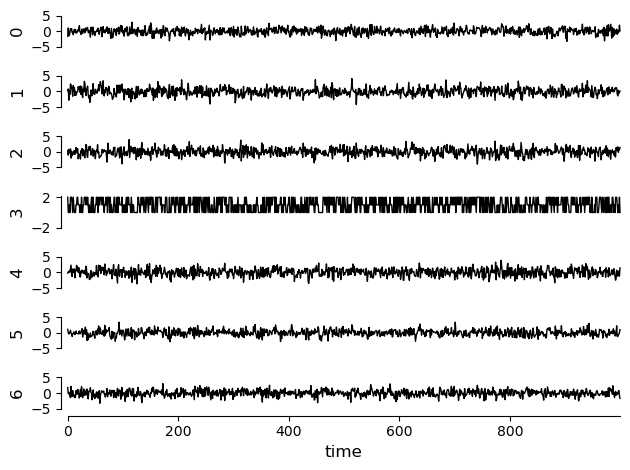

In [29]:
def lin_f(x): return x

coeff = .5
links_coeffs = {
                0: [], 
                1: [((0, 0), coeff, lin_f), ((5, 0), coeff, lin_f)], 
                2: [((1, 0), -coeff, lin_f), ((5, 0), coeff, lin_f)],
                3: [((1, 0), 1., lin_f), ((2, 0), coeff, lin_f), ((6, 0), coeff, lin_f), ((7, 0), coeff, lin_f)],
                4: [((5, 0), coeff, lin_f), ((7, 0), coeff, lin_f)], 
                5: [],
                6: [],
                7: [],
                }
# Observational data
T = 1000
data, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7)

# Let's make Y a categorical variable using quantile binning
bins = 3
data[:,Y[0][0]] = pp.quantile_bin_array(data[:,Y[0][0]].reshape(len(data), 1), bins=bins).squeeze()

# Time series no 7 is unobserved confounder
data = data[:, [0,1,2,3,4,5,6]]
dataframe = pp.DataFrame(data)
tp.plot_timeseries(dataframe); plt.show()

Then we fit the total effect using ``LogisticRegression``. By default, the ouput of ``predict(...)`` is averaged, which makes sense for continuous target variables. Here, instead, we get categorical predictions and apply np.bincount (with the correct number of categories) to get the predicted distributions for each intervention value.

In [30]:
# Interventional data for a range of intervention values
intervention_data = np.linspace(-5, 5, 10)

# Fit causal effect model from observational data
causal_effects.fit_total_effect(
        dataframe=dataframe, 
        estimator=LogisticRegression(),
        adjustment_set='optimal',
        conditional_estimator=None,  
        data_transform=None,
        mask_type=None,
        )

# Predict effect of interventions
intervention_data_here = np.tile(intervention_data.reshape(10, 1), (1, 2))

# Instead of the default mean function for continuous target variables, here we get categorical predictions
# and apply np.bincount to get their interventional distribution
def aggregation_func(x):
    x = x.astype('int64')
    return np.bincount(x, minlength=bins)

estimated_causal_effects = causal_effects.predict_total_effect( 
        intervention_data=intervention_data_here,
#         conditions_data=conditions_data,
        aggregation_func = aggregation_func,
        )
for ido, dox in enumerate(intervention_data):
    print("Interventional distribution for do(X=%.3f) = %s" %(dox, str(estimated_causal_effects[ido, 0])))


Interventional distribution for do(X=-5.000) = [1000    0    0]
Interventional distribution for do(X=-3.889) = [1000    0    0]
Interventional distribution for do(X=-2.778) = [997   3   0]
Interventional distribution for do(X=-1.667) = [918  73   9]
Interventional distribution for do(X=-0.556) = [441 457 102]
Interventional distribution for do(X=0.556) = [ 60 474 466]
Interventional distribution for do(X=1.667) = [  2 146 852]
Interventional distribution for do(X=2.778) = [  0  19 981]
Interventional distribution for do(X=3.889) = [  0   1 999]
Interventional distribution for do(X=5.000) = [   0    0 1000]


Here the distributions gradually shift from the lower to the upper categories.

### Conditional causal effects

We now give an example application for the causal effect $\mathbb{E}[Y|do(X=x), S=s]$ *conditional* on some values $S=s$ of another variable $S$ in the graph. 

$S$ may be a continuous variable, but here we consider the case where it is binary $\{-1, 1\}$ and defines two causal regimes:

$$
Y=0.7*S*X+Z+\eta^Y
$$

I.e., for $S=1$ we have $Y=0.7*X+Z+\eta^Y$ and for $S=-1$ we have $Y=-0.7*X+Z+\eta^Y$. $S$ also causes $Z$ here, and $Z$ causes $X$.

In [31]:
T = 10000

Sdata = np.random.choice([-1., 1.], size=T)
Zdata = Sdata*np.random.randn(T)
Xdata = np.random.randn(T) + Zdata
Ydata = 0.7*Sdata*Xdata + Zdata + np.random.randn(T)
data = np.vstack((Xdata, Ydata, Sdata, Zdata)).T
dataframe = pp.DataFrame(data)


##
## Initializing CausalEffects class
##

Input:

graph_type = admg
X = [(0, 0)]
Y = [(1, 0)]
S = [(2, 0)]
M = []





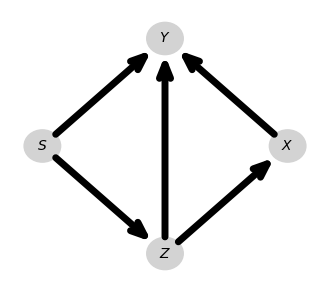

In [32]:
graph =  np.array([['', '-->', '', '<--'],
                   ['<--', '', '<--', '<--'],
                   ['', '-->', '', '-->'],
                   ['-->', '-->', '<--', '']], dtype='<U3')

X = [(0,0)]
Y = [(1,0)]
S = [(2,0)]
causal_effects = CausalEffects(graph, graph_type='admg', X=X, Y=Y, S=S, hidden_variables=None, 
                            verbosity=1)
# Just for plotting purposes
var_names = ['$X$', '$Y$', '$S$', '$Z$']
tp.plot_graph(graph = causal_effects.graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (4, 4),
        ); plt.show()

Here we choose a neural network for the estimator and linear regression for the conditional estimator. 

In [33]:
# Fit causal effect model from observational data
causal_effects.fit_total_effect(
        dataframe=dataframe, 
        estimator=MLPRegressor(max_iter=200),
        adjustment_set='optimal',
        conditional_estimator=LinearRegression(),  
        data_transform=None,
        mask_type=None,
        )

In [34]:
# Set X to intervened values given S=-1, 1
# S=-1
for cond_value in [-1, 1]:
    conditions_data=cond_value*np.ones((1, 1))
    
    intervention_data = 1.*np.ones((1, 1))
    y1 = causal_effects.predict_total_effect( 
            intervention_data=intervention_data,
            conditions_data=conditions_data,
            )

    intervention_data = 0.*np.ones((1, 1))
    y2 = causal_effects.predict_total_effect( 
            intervention_data=intervention_data,
            conditions_data=conditions_data,
            )
    
    beta = (y1 - y2)
    print("Causal effect for S = % .2f is %.2f" %(cond_value, beta))


Causal effect for S = -1.00 is -0.67
Causal effect for S =  1.00 is 0.70


This is quite well estimating the correct causal effect which for $S=1$ is $\beta=0.7$ and for $S=-1$ $\beta=-0.7$.

## Causal effects in time series DAGs

Next, we investigate causal effect estimation from the stationary DAG above.



##
## Initializing CausalEffects class
##

Input:

graph_type = stationary_dag
X = [(1, -2)]
Y = [(2, 0)]
S = []
M = [(1, 0), (2, -1), (2, -2), (1, -1)]



Oset =  [('$X^2$', -3), ('$X^1$', -4), ('$X^1$', -3)]


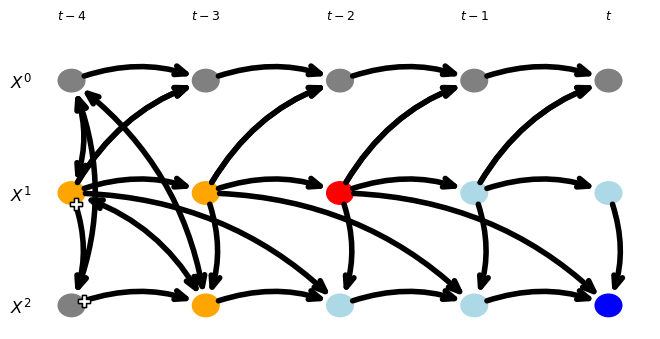

In [35]:
graph =  np.array([[['', '-->', ''],
                    ['', '', ''],
                    ['', '', '']],
                   [['', '-->', ''],
                    ['', '-->', ''],
                    ['-->', '', '-->']],
                   [['', '', ''],
                    ['<--', '', ''],
                    ['', '-->', '']]], dtype='<U3')

X = [(1,-2)]
Y = [(2,0)]
causal_effects = CausalEffects(graph, graph_type='stationary_dag', X=X, Y=Y, S=None, 
                               hidden_variables=None, 
                            verbosity=1)
var_names = ['$X^0$', '$X^1$', '$X^2$']

opt = causal_effects.get_optimal_set()
print("Oset = ", [(var_names[v[0]], v[1]) for v in opt])
special_nodes = {}
for node in causal_effects.X:
    special_nodes[node] = 'red'
for node in causal_effects.Y:
    special_nodes[node] = 'blue'
for node in opt:
    special_nodes[node] = 'orange'
for node in causal_effects.M:
    special_nodes[node] = 'lightblue'

    
tp.plot_time_series_graph(graph = causal_effects.graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (8, 4),
        special_nodes=special_nodes
        ); plt.show()

In this extended ADMG constructed from the stationary input DAG (as described above) the optimal adjustment set is colored in orange, the mediators are in light blue. Since the whole optimal adjustment set is included in this lag-range, the adjustment is valid. 

Let's generate some data for an SCM with this stationary DAG.

In [36]:
coeff = .5
links_coeffs = {
                0: [((0, -1), coeff, lin_f), ((1, -1), coeff, lin_f)], 
                1: [((1, -1), coeff, lin_f),], 
                2: [((2, -1), coeff, lin_f), ((1, 0), coeff, lin_f), ((1,-2), coeff, lin_f)],
                }
# Observational data
T = 10000
data, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7)
dataframe = pp.DataFrame(data)


Now we fit and predict the effect of the two interventions $x=1$ and $x'=0$.

In [37]:
# Fit causal effect model from observational data
causal_effects.fit_total_effect(
        dataframe=dataframe, 
        estimator=LinearRegression(),
        adjustment_set='optimal',
        )

In [38]:
intervention_data = 1.*np.ones((1, 1))
y1 = causal_effects.predict_total_effect( 
        intervention_data=intervention_data,
        )

intervention_data = 0.*np.ones((1, 1))
y2 = causal_effects.predict_total_effect( 
        intervention_data=intervention_data,
        )

beta = (y1 - y2)
print("Causal effect is %.2f" %(beta))



Causal effect is 0.85


In this linear model the effect is equivalent to the sum over the product of all coefficients along causal paths from $X^1_{t-2}$ to $X^2_{t}$.

## Estimating linear effects with the Wright estimator

We consider a DAG-version of the complex graph in the introduction.


##
## Initializing CausalEffects class
##

Input:

graph_type = dag
X = [(0, 0), (1, 0)]
Y = [(3, 0)]
S = []
M = [(2, 0)]



Oset =  [('$Z_1$', 0), ('$Z_2$', 0), ('$Z_3$', 0)]


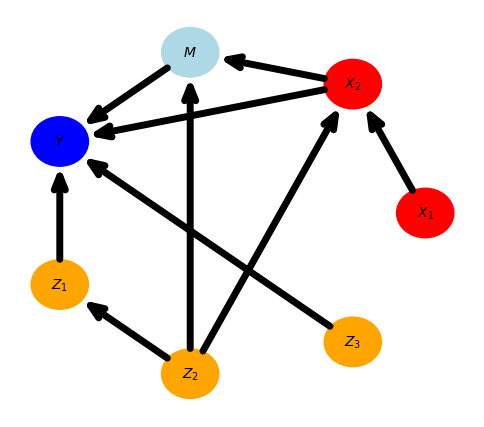

In [39]:
graph =  np.array([['', '-->', '', '', '', '', ''],
                   ['<--', '', '-->', '-->', '', '<--', ''],
                   ['', '<--', '', '-->', '', '<--', ''],
                   ['', '<--', '<--', '', '<--', '', '<--'],
                   ['', '', '', '-->', '', '<--', ''],
                   ['', '-->', '-->', '', '-->', '', ''],
                   ['', '', '', '-->', '', '', '']], dtype='<U3')

X = [(0,0), (1,0)]
Y = [(3,0)]
causal_effects = CausalEffects(graph, graph_type='dag', X=X, Y=Y, S=None, hidden_variables=None, 
                            verbosity=1)
# Just for plotting purposes
var_names = ['$X_1$', '$X_2$', '$M$', '$Y$', '$Z_1$', '$Z_2$', '$Z_3$']

opt = causal_effects.get_optimal_set()
print("Oset = ", [(var_names[v[0]], v[1]) for v in opt])
special_nodes = {}
for node in causal_effects.X:
    special_nodes[node] = 'red'
for node in causal_effects.Y:
    special_nodes[node] = 'blue'
for node in opt:
    special_nodes[node] = 'orange'
for node in causal_effects.M:
    special_nodes[node] = 'lightblue'

    
tp.plot_graph(graph = causal_effects.graph,
        var_names=var_names, 
#         save_name='Example.pdf',
        figsize = (6, 6),
        special_nodes=special_nodes
        ); plt.show()

Let's generate some data.

In [40]:
def lin_f(x): return x
coeff = .5
links_coeffs = {
                0: [], 
                1: [((0, 0), coeff, lin_f), ((5, 0), coeff, lin_f)], 
                2: [((1, 0), coeff, lin_f), ((5, 0), coeff, lin_f)],
                3: [((1, 0), coeff, lin_f), ((2, 0), coeff, lin_f), ((6, 0), coeff, lin_f), ((4, 0), coeff, lin_f)],
                4: [((5, 0), coeff, lin_f)], 
                5: [],
                6: [],
                }
T = 10000
data, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7)
dataframe = pp.DataFrame(data)

We fit and predict with Wright's method. Next to the data handling arguments ``fit_wrights_effect`` takes:

* ``mediation : None or 'direct' or list of tuples``: If None, the total effect is estimated, if 'direct', only the direct effect is estimated, else only those causal paths are considerd that pass at least through one of these mediator nodes.
* ``method : {'parents', 'links_coeffs', 'optimal'}``: Method to use for estimating Wright's path coefficients. If 'optimal', the Oset is used, if 'links_coeffs', the coefficients in links_coeffs are used, if 'parents', the parents are used (only valid if there are no bi-directed links adjacent to mediators or Y). 'links_coeffs' can be used for testing purposes if you play around with toy models.
* ``links_coeffs : dict``: Only used if method = 'links_coeffs'. Dictionary of format: {0:[((i, -tau), coeff),...], 1:[...],  ...} for all variables where i must be in [0..N-1] and tau >= 0 with number of variables N. coeff must be a float.

The default is ``method='parents'`` which is suitable here since we deal with a DAG.

In [41]:
causal_effects.fit_wright_effect(dataframe=dataframe)

intervention_data = 1.*np.ones((1, 2))
y1 = causal_effects.predict_wright_effect( 
        intervention_data=intervention_data,
        )

intervention_data = 0.*np.ones((1, 2))
y2 = causal_effects.predict_wright_effect( 
        intervention_data=intervention_data,
        )

beta = (y1 - y2)
print("Causal effect is %.2f" %(beta))


Causal effect is 0.75


This is the expected result since there is one direct link with coefficient 0.5 and an indirect paths with an effect $0.5*0.5$.

Finally, the option ``mediation`` allows to consider only direct and mediated effects. Let's measure how much of the total effect is mediated through $M$.

In [42]:
considered_mediators = [(2, 0)]
causal_effects.fit_wright_effect(dataframe=dataframe, mediation=considered_mediators)

intervention_data = 1.*np.ones((1, 2))
y1 = causal_effects.predict_wright_effect( 
        intervention_data=intervention_data,
        )

intervention_data = 0.*np.ones((1, 2))
y2 = causal_effects.predict_wright_effect( 
        intervention_data=intervention_data,
        )

beta = (y1 - y2)
print("Mediated causal effect through M = %s is %.2f" %(considered_mediators, beta))

Mediated causal effect through M = [(2, 0)] is 0.23


And the direct effect is:

In [43]:
causal_effects.fit_wright_effect(dataframe=dataframe, mediation='direct')

intervention_data = 1.*np.ones((1, 2))
y1 = causal_effects.predict_wright_effect( 
        intervention_data=intervention_data,
        )

intervention_data = 0.*np.ones((1, 2))
y2 = causal_effects.predict_wright_effect( 
        intervention_data=intervention_data,
        )

beta = (y1 - y2)
print("Direct causal effect is %.2f" %(beta))

Direct causal effect is 0.51


The CausalEffects class generalizes the ``LinearMediation`` class of tigramite, which only applies to linear effects in time series graphs. Due to its implementation, the ``LinearMediation`` may be much faster, though.

## Bootstrap-based confidence intervals

You can estimate confidence intervals for both general total effect and Wright-based effect estimates.

In [44]:
# Let's generate shorter length data
T = 100
data, nonstat = toys.structural_causal_process(links_coeffs, T=T, noises=None, seed=7)
dataframe = pp.DataFrame(data)

# First for the Wright method with effect estimate being 0.75 above
causal_effects.fit_bootstrap_of(
    method='fit_wright_effect',
    method_args={'dataframe':dataframe},
    boot_samples=1000)

intervention_data = 1.*np.ones((1, 2))
conf = causal_effects.predict_bootstrap_of(
    method='predict_wright_effect',
    method_args={'intervention_data':intervention_data})
print(conf.shape)



##
## Running Bootstrap of fit_wright_effect 
##

boot_samples = 1000 

boot_blocklength = 1 

(2, 1)



##
## Running Bootstrap of fit_total_effect 
##

boot_samples = 1000 

boot_blocklength = 1 



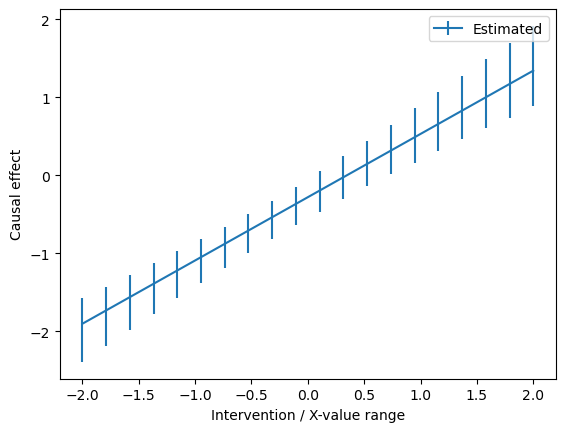

In [45]:
# Now the total effect estimate
# First fit 
causal_effects.fit_total_effect(dataframe=dataframe, estimator=LinearRegression())

# Then its confidence interval
causal_effects.fit_bootstrap_of(
    method='fit_total_effect',
    method_args={'dataframe':dataframe,  
                 'estimator':LinearRegression()},
    boot_samples=1000)

# Then predict
intervention_data = np.tile(np.linspace(-2, 2, 20).reshape(20, 1), (1, 2))
estimated_causal_effects = causal_effects.predict_total_effect( 
        intervention_data=intervention_data,
#         conditions_data=conditions_data,
        )
estimated_confidence_intervals = causal_effects.predict_bootstrap_of(
    method='predict_total_effect',
    method_args={'intervention_data':intervention_data},
    conf_lev=0.9)

plt.errorbar(intervention_data[:,0], estimated_causal_effects[:,0], 
             np.abs(estimated_confidence_intervals - estimated_causal_effects[:,0]), label="Estimated")
plt.xlabel('Intervention / X-value range')
plt.ylabel('Causal effect')
plt.legend()
plt.show()
